<a href="https://colab.research.google.com/github/ankurmcw/computational_data_science/blob/master/Resume_Classification_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mini-Project: Resume Classification

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data preprocessing, EDA and feature extraction on the Resume dataset
* perform multinomial Naive Bayes classification on the Resume dataset

### Dataset description

The data is in CSV format, with two features: Category, and Resume.

**Category** -  Industry sector to which the resume belongs to, and

**Resume** - The complete CV (text) of the candidate.

## Information

Companies often receive thousands of resumes for each job posting and employ dedicated screening officers to screen qualified candidates. Finding suitable candidates for an open role from a database of 1000s of resumes can be a tough task. Automated resume categorization can speeden the candidate selection process. Such automation can really ease the tedious process of fair screening and shortlisting the right candidates and aid quick decisionmaking.

To learn more about this, click [here](https://www.sciencedirect.com/science/article/pii/S187705092030750X).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib.gridspec import GridSpec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### Downloading the data

In [ ]:
#@title Download the dataset
!wget -qq xxx
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


**Exercise 1: Read the UpdatedResumeDataset.csv dataset**

**Hint:** pd.read_csv()

In [ ]:
# read the dataset
base_df = pd.read_csv('/content/UpdatedResumeDataSet.csv')

In [ ]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [ ]:
base_df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [ ]:
base_df.describe()

,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


### Pre-processing and EDA

**Exercise 2: Display  all the categories of resumes and their counts in the dataset**



In [ ]:
# Display the distinct categories of resume
base_df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [ ]:
# Display the distinct categories of resume and the number of records belonging to each category
base_df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

**Exercise 3: Create the count plot of different categories**

**Hint:** Use `sns.countplot()`

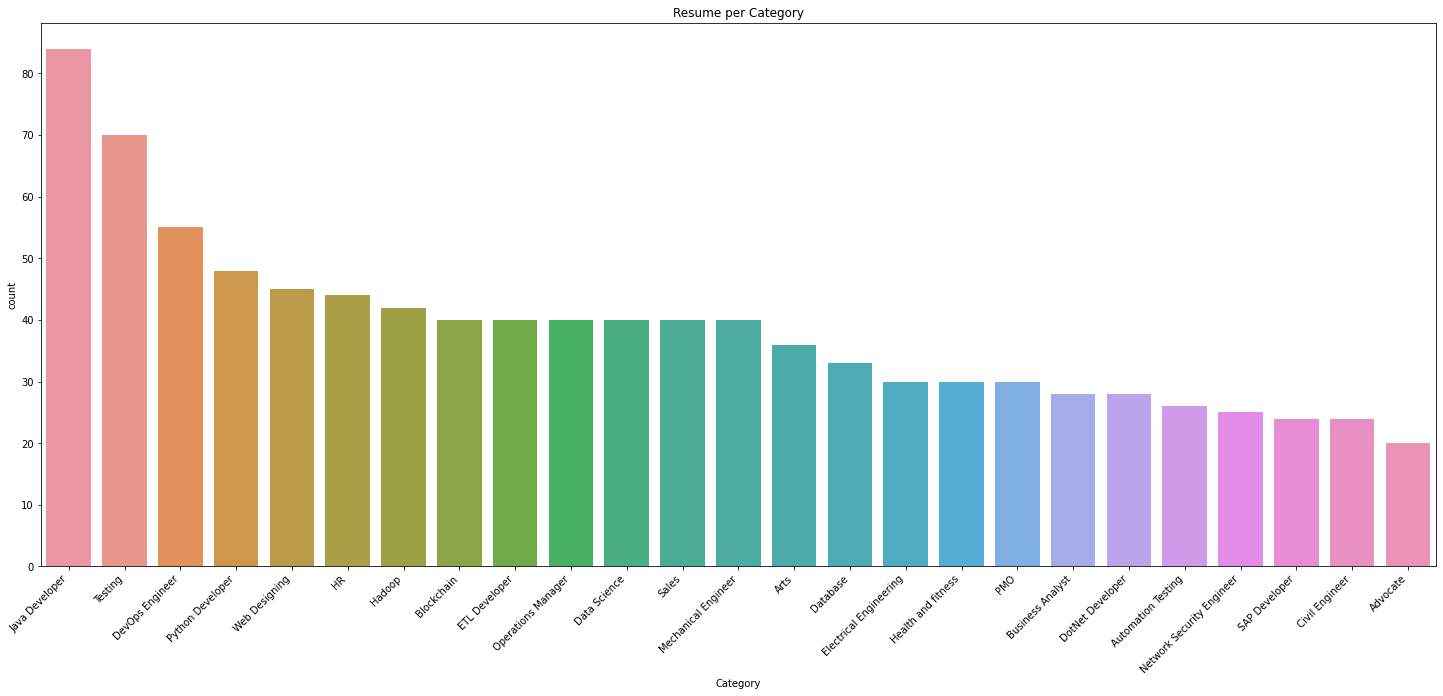

In [ ]:
plt.subplots(1, figsize=(25,10))
plt.xticks(rotation=45, horizontalalignment='right')
plt.xlabel('categories')
plt.title('Resume per Category')
sns.countplot(base_df['Category'], order=base_df['Category'].value_counts().index)
plt.show()

**Exercise 4: Create a pie plot depicting the percentage of resume distributions category-wise**

**Hint:** Use [plt.pie()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html) and [plt.get_cmap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for color mapping the pie chart.

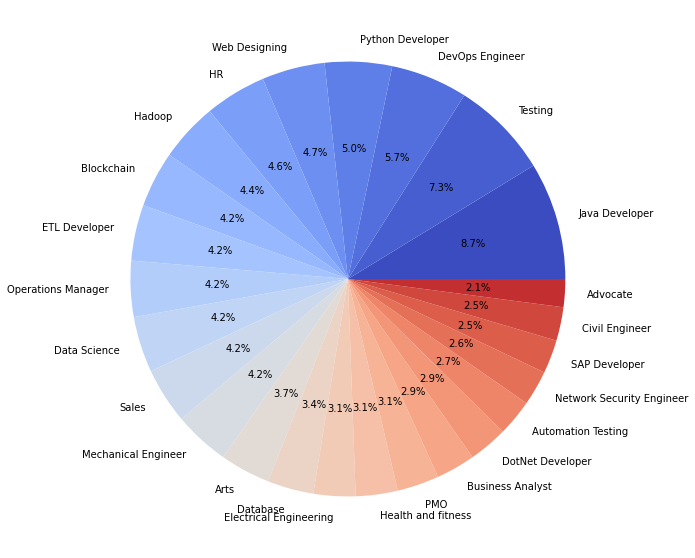

In [ ]:
targetCounts = base_df['Category'].value_counts()
targetLabels  = targetCounts.index.values
# Make square figures and axes
fig = plt.figure(1, figsize=(10,10))
the_grid = GridSpec(1, 1, figure=fig)
fig.add_subplot(the_grid[0, 0])

# YOUR CODE HERE to display pie chart with color coding (eg. `coolwarm`)
theme = plt.get_cmap('coolwarm')
c_map = [theme(1 * i / len(targetCounts)) for i in range(len(targetCounts))]
plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', colors = c_map)
plt.show()

**Exercise 5: Convert all the `Resume` text to lower case**




In [ ]:
# Convert all characters to lowercase
base_df['Resume'] = base_df['Resume'].apply(lambda k: k.lower())

In [ ]:
base_df['Resume'].head()

0    skills * programming languages: python (pandas...
1    education details \r\nmay 2013 to may 2017 b.e...
2    areas of interest deep learning, control syste...
3    skills â¢ r â¢ python â¢ sap hana â¢ table...
4    education details \r\n mca   ymcaust,  faridab...
Name: Resume, dtype: object

### Cleaning resumes' text data

**Exercise 6: Define a function to clean the resume text**

In the text there are special characters, urls, hashtags, mentions, etc. Remove the following:  

* URLs: For reference click [here](https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python)
* RT | cc: For reference click [here](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/)
* Hashtags, # and Mentions, @
* punctuations
* extra whitespace

PS: Use the provided reference similarly for removing any other such elements.

After cleaning as above, store the Resume Text in a separate column (New Feature).


In [ ]:
import re
def cleanResume(resumeText):
  resumeText = re.sub(r'http\S+', '', resumeText, flags=re.MULTILINE)                # remove URLS
  resumeText = re.sub(r'[^a-z0-9\s]', '', resumeText, flags=re.MULTILINE)            # remove Hashtags - #, Mentions - @ and punctuations
  resumeText = re.sub(r'(\r)', '', resumeText, flags=re.MULTILINE)                   # remove \r
  resumeText = re.sub(r'(\n)', ' ', resumeText, flags=re.MULTILINE)                  # remove \n
  resumeText = re.sub(' +', ' ', resumeText, flags=re.MULTILINE)                    # remove extra spaces
  return resumeText

In [ ]:
text = '''hello https://matplotlib.org/3.5.0/tutorials/intermediate/gridspec.html
world https://www.regextester.com/
https://seeing-theory.brown.edu/bayesian-inference/index.html !!!!
my skills â¢ r â¢ python â¢ sap hana
education details \r\n mca   ymcaust,  faridabad'''

print(cleanResume(text))

hello world my skills r python sap hana education details mca ymcaust faridabad


In [ ]:
 # apply the function defined above and save the
 base_df['cleaned_resume'] = base_df['Resume'].apply(cleanResume)

In [ ]:
base_df['cleaned_resume'].head()

0    skills programming languages python pandas num...
1    education details may 2013 to may 2017 be uitr...
2    areas of interest deep learning control system...
3    skills r python sap hana tableau sap hana sql ...
4    education details mca ymcaust faridabad haryan...
Name: cleaned_resume, dtype: object

In [ ]:
sent_lens = []
for i in base_df.cleaned_resume:
    # print(i)
    length = len(i.split())
    sent_lens.append(length)

print(len(sent_lens))
print(max(sent_lens))

962
2014


### Stopwords removal

The stopwords, for example, `and, the, was, and so forth` etc. appear very frequently in the text and are not helpful in the predictive process. Therefore these are usually removed for text analytics and text classification purposes.

1. Tokenize the input words into individual tokens and store it in an array
2. Using `nltk.corpus.stopwords`, remove the stopwords

Hint: See Module 1 - Assignment 4 'Text Classification using Naive Bayes'


**Exercise 7: Use `nltk` package to find the most common words from the `cleaned resume` column**

**Hint:**
* Use `nltk.FreqDist`


In [ ]:
# stop words
# YOUR CODE HERE to print the stop words in english language
stopword_list = stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# most common words
# YOUR CODE HERE
# removing the stopwords
def remove_stopwords(text):
    # splitting strings into tokens (list of words)
    tokens = word_tokenize(text)
    freqDist = nltk.FreqDist(tokens)
    # tokens = [token.strip() for token in tokens]
    tokens = freqDist.keys()
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [ ]:
base_df['cleaned_resume'] = base_df['cleaned_resume'].apply(remove_stopwords)

In [ ]:
base_df['cleaned_resume'].head()

0    skills programming languages python pandas num...
1    education details may 2013 2017 uitrgpv data s...
2    areas interest deep learning control system de...
3    skills r python sap hana tableau sql pal ms lu...
4    education details mca ymcaust faridabad haryan...
Name: cleaned_resume, dtype: object

<function matplotlib.pyplot.show>

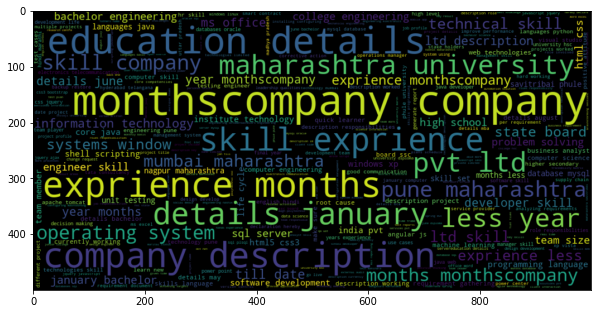

In [ ]:
# YOUR CODE HERE to show the most common word using WordCloud

plt.figure(figsize=(10,10))
resume_text = ' '.join(text for text in base_df.cleaned_resume)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
resume_words = WC.generate(resume_text)
plt.imshow(resume_words, interpolation='bilinear')
plt.show

**Exercise 8: Convert the categorical variable `Category` to a numerical feature and make a different column, which can be treated as the target variable**

**Hint:** Use [`sklearn.preprocessing.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) method

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

base_df['target'] = le.fit_transform(base_df['Category'])

In [ ]:
base_df[['Category', 'target']].sample(10)

,Category,target
687,PMO,19
755,Hadoop,13
667,Network Security Engineer,17
854,Blockchain,3
944,Testing,23
725,Database,7
66,HR,12
602,DevOps Engineer,8
610,DevOps Engineer,8
823,ETL Developer,10


In [ ]:
le.transform(['Electrical Engineering', 'Testing', 'Database', 'Electrical Engineering'])

array([11, 23,  7, 11])

### Feature Extraction

**Exercise 9: Convert the text to feature vectors by applying `tfidf vectorizer` to the Label encoded category made above**

`TF-IDF`will tokenize documents, learn the vocabulary, inverse document frequency weightings, and allow you to encode new documents

**Hint:** Use [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).



In [ ]:
base_df.head(1)

,Category,Resume,cleaned_resume,target
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6


In [ ]:
# YOUR CODE HERE
tv = TfidfVectorizer(min_df=0, max_df=0.2, use_idf=True, ngram_range=(1,2))
vectorized_resume = tv.fit_transform(base_df.iloc[:, 2].values)

In [ ]:
vectorized_resume

<962x32735 sparse matrix of type '<class 'numpy.float64'>'
	with 297318 stored elements in Compressed Sparse Row format>

## Naive Bayes Classifier

**Exercise 10: Split the data into train and test sets. Apply Naive Bayes Classifier (MultinomialNB) and evaluate the model predictions**

**Hint:** Use Vectorized features made above as X and Labelled category as y.

In [ ]:
X = vectorized_resume
y = base_df.iloc[:, 3].values

print(X.shape)
print(y.shape)

(962, 32735)
(962,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(769, 32735)
(193, 32735)
(769,)
(193,)


In [ ]:
mnb = MultinomialNB()
model = mnb.fit(X_train, y_train)

In [ ]:
predictions = mnb.predict(X_test)
# len(predictions)

print('predictions:', predictions)

predictions: [ 6 18  8  4 16 18 16  8 11 15 23 11 19 14  4 14 10  9 21  7  8 13 20  6
 15  2 16 15 14  5  3 20 15 15  9  9 23  5 22 16 11 16 10 12  1 22 23 24
  2 16 18 23 24  1 16  1  6 24 17 20 16 20 15  6 16  4 12 13 19 12 20  3
 14 24 12  4 20 15  1  6  8  1  5  9 14 16 19 21 23 22  3  9  0 22 19 15
 19  7 23 14 20 12 23 18 18 13 15 17  1 15 24 23 15  4 11 18 15  3 23 16
 16 12  8 17  2  9 23  7  8  6 24 22  4 13 21 23 11  5 24  9 13  0  6  1
 13  8 18 15  4  8  5 11  6 14 23 14 23 21 20  9 22 15 20  2  9 17 15 15
 19 15 11 22  5  4 15 13  7  3 24 11 13 20  5  3 22  7 24 10  2 15 24 20
 10]


In [ ]:
print(le.inverse_transform([15]))

['Java Developer']


In [ ]:
score = accuracy_score(y_test, predictions)
print("score :", score)

score : 0.9844559585492227


In [ ]:
cm = confusion_matrix(y_test, predictions, labels=range(25))
print('confusion matrix:\n', cm)

confusion matrix:
 [[ 2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  

## Optional: Create a Gradio based web interface to test and display the model predictions

In [ ]:
def predict_resume_category(text):
    text = text.lower()
    text = cleanResume(text)
    text = remove_stopwords(text)
    vectorized_text = tv.transform([text])
    predicted_label = mnb.predict(vectorized_text)
    return le.inverse_transform([predicted_label])[0]

In [ ]:
print(predict_resume_category('I am Java developer'))

Java Developer


In [ ]:
    !pip -qq install gradio

In [ ]:
import gradio

In [ ]:
# Input from user
in_review = gradio.inputs.Textbox(lines=2, placeholder=None, default="I am Java developer", label='Enter your resume')

In [ ]:
# Output prediction
out_label = gradio.outputs.Textbox(type="auto", label='Predicted Category')

In [ ]:
# Gradio interface to generate UI link

iface = gradio.Interface(
  fn = predict_resume_category,
  inputs = [in_review],
  outputs = [out_label])
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://28601.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7faba0cea690>,
 'http://127.0.0.1:7862/',
 'https://28601.gradio.app')

**Report Analysis**
- Which method(s), other than TF-IDF could be used for text to vector conversion?
- Discuss about the `alpha`, `class_prior` and `fit_prior` parameters in sklearn `MultinomialNB`


Dataset Source Reference: [Resume dataset](https://www.kaggle.com/gauravduttakiit/resume-dataset/download)